<img src="https://raw.githubusercontent.com/pymc-devs/brand/main/pymc/pymc_logos/PyMC_banner.svg" width=300></img>
<img src="https://raw.githubusercontent.com/arviz-devs/arviz-project/main/arviz_logos/ArviZ.png#gh-light-mode-only" width=200></img>
# Probabilistic Programming: Multilevel Modelling of Temperature data

Using temperature data to explore the possibilities of multilevel (aka. heirachical) data modelling using probabilistic programming methods.

The aim here is to start from basic Bayesian approaches to estimating the temperature of a water bath, and build up to more complex scenarios using [PyMC](https://www.pymc.io/welcome.html) and [ArviZ](https://python.arviz.org/en/stable/).

Use the `data-science-cop-pymc` environment to run this notebook.


Author: Hamish Steptoe <hamish.steptoe@metoffice.gov.uk>


In [12]:
%matplotlib inline
import pymc as pm
import arviz as az
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Some basic data

Imagine we want to estimate the temperature of a water-bath (ie. temp is constant) using a thermometer.  Imagine we take 60 measurements.  How can we work out the likley temperature of water bath, and estimate the uncertainty.

Let's start by creating some dummy data...

Text(0.5, 0, 'Observation #')

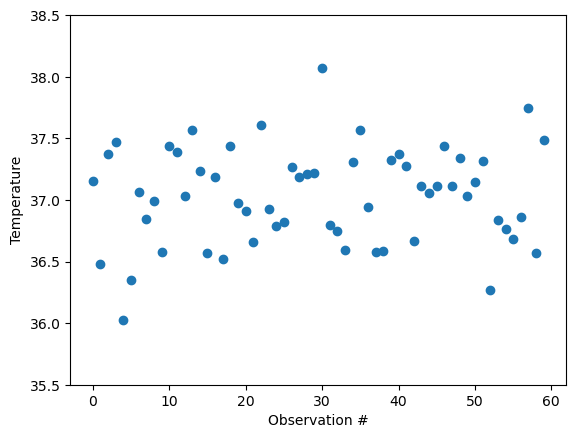

In [25]:
# Set-up random number generator
rng = default_rng(seed=42)
# Set up dummy temp data
true_temp_mean = 37.
# Number of observations
n=60
# Draw n 'observations' simulated from a Gaussian distribution with mean of true_temp 
# and standard deviation of 0.1oC
obs_temps = rng.normal(loc=true_temp_mean, scale=0.5, size=n)
# obs_temps[np.random.choice(len(obs_temps))] = 0
plt.plot(obs_temps, 'o')
plt.ylim([35.5, 38.5])
plt.ylabel('Temperature')
plt.xlabel('Observation #')

---
## Basic 1-thermometer model

In [34]:
# Bayesian model
with pm.Model() as basic_model:
    # Priors for unknown temp
    # We know the water isn't frozen, or boiling, so use a bounded distribution.
    # Take a guess at it being in the lower half of this range
    mean = pm.Normal('μ', mu=obs_temps.mean(), sigma=2*obs_temps.std())
    std = pm.Exponential("σ", lam=1)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mean, sigma=std, observed=obs_temps)

PyMC can plot a 'plate'-style visual representation of this:

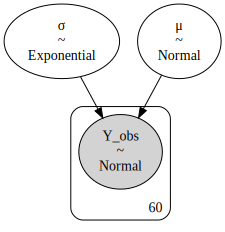

In [35]:
pm.model_to_graphviz(basic_model)

Or as a mathematical formula:

In [36]:
basic_model

Note the priors here, estimated for the mean and standard deviation of temperature.  What we're aiming for is someting 'informative' without being overly prescriptive.  Working out the influence of your priors on your posterior is a whole branch a Bayesian analysis that we won't go into here, but having a good prior is generally thought to be quite important.  Uninformative priors are also a thing, essentially defining a flat Uniform distribution, but in most situations aren't recommended.

The prior on the mean temperature `mean` is a  Normal distribution.  The `lam` parameter in the `pm.Exponential` distribution implies a mean of 0.5°C and variance of 0.25°C.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


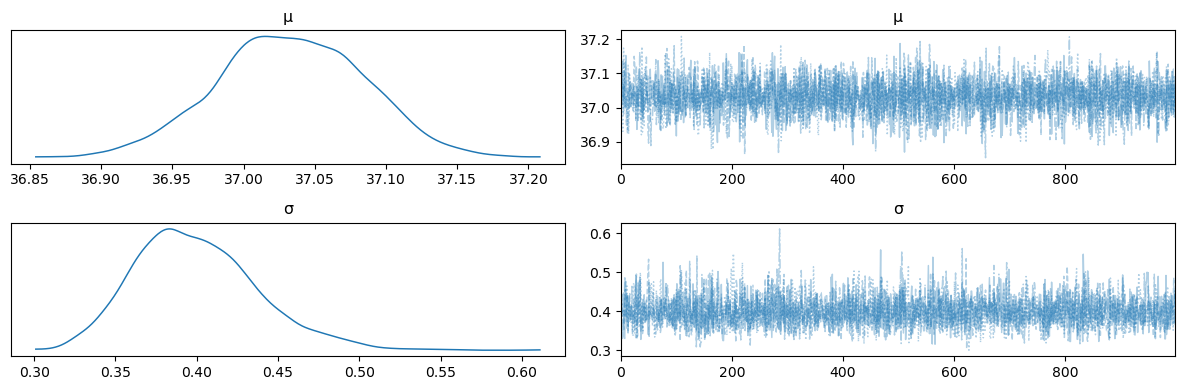

In [37]:
with basic_model:
    basic_trace = pm.sample(chains=4)
az.plot_trace(basic_trace, combined=True)
plt.tight_layout()

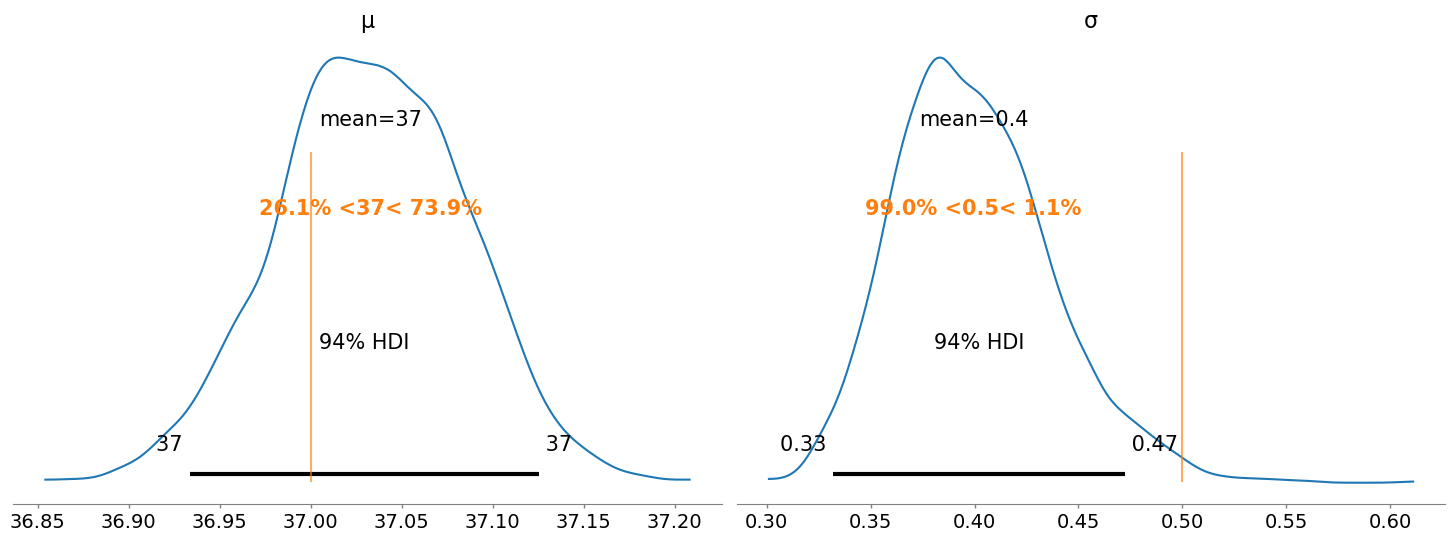

In [38]:
az.plot_posterior(basic_trace, ref_val= {"μ": [{"ref_val": true_temp_mean}], "σ": [{"ref_val": 0.5}]})
plt.tight_layout()

---
## Multiple thermometers

Now image we have multiple thermometers measure the same water bath.  They are all sampling the same thing (same water bath as above), but now each thermometers' individual measurement charatceristics should be accounted for.  In this case we label them using the python 0-index convention for consistency with the code.

Remember, the true temp we set at the begining was 37°C.

Let's imagine that ther thermometers have the following characteristics:

* Thermometer 0: Accurate & precise thermometer
* Thermometer 1: Accurate but imprecise thermometer
* Thermometer 2: Inaccurate (cold bias) but precise thermometer

Generate some dummy data:

<Axes: xlabel='Temp', ylabel='Density'>

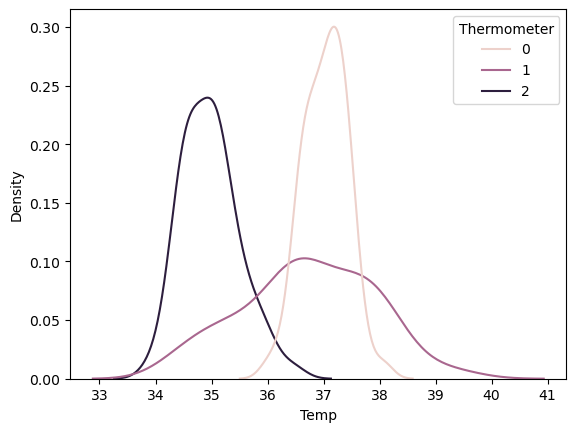

In [26]:
obs_temps0 = obs_temps  # Good, accurate thermometer
obs_temps1 = rng.normal(loc=true_temp_mean, scale=1.5, size=n) # Accurate but imprecise thermometer
obs_temps2 = rng.normal(loc=true_temp_mean-2, scale=0.5, size=n) # Inaccurate (cold bias) but precise thermometer

all_obs = np.array([obs_temps0, obs_temps1, obs_temps2]).flatten()  # NB. remember the order the array is created

# An array describing which of the obs belong to which thermometer
obs_idx = np.array([np.repeat(0, n), np.repeat(1, n), np.repeat(2, n)]).flatten()
obs_sample = np.tile(range(n), 3)

# Make dataframe
df = pd.DataFrame(data=zip(obs_sample, obs_idx, all_obs), columns=["Sample", "Thermometer", "Temp"], )
sns.kdeplot(data=df, x="Temp", hue="Thermometer")

For comparison, lets estimate a naive mean and standard deviation across all the data

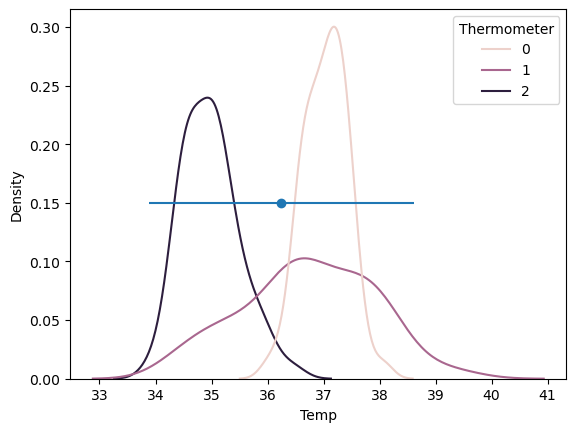

In [27]:
sns.kdeplot(data=df, x="Temp", hue="Thermometer")
plt.plot(df.Temp.mean(), 0.15, 'o')
plt.hlines(xmin=df.Temp.mean()-2*df.Temp.std(), xmax=df.Temp.mean()+2*df.Temp.std(), y=0.15)

Start by applying our basic 1-thermometer model to this new data:

In [39]:
with pm.Model() as basic_model:
    # Priors for unknown temp
    mean = pm.Normal('μ', mu=obs_temps.mean(), sigma=2*obs_temps.std())
    std = pm.Exponential("σ", lam=2)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mean, sigma=std, observed=all_obs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


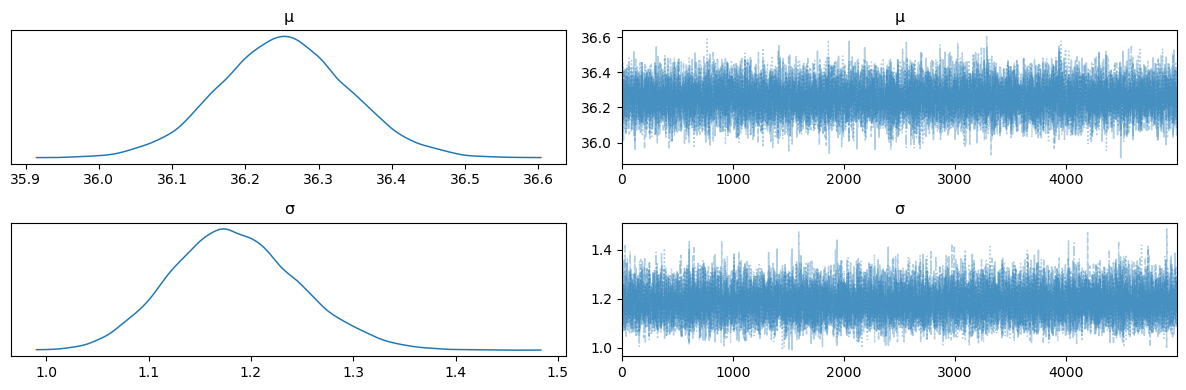

In [40]:
with basic_model:
    basic_trace = pm.sample(5000, chains=4)

az.plot_trace(basic_trace, combined=True)
plt.tight_layout()

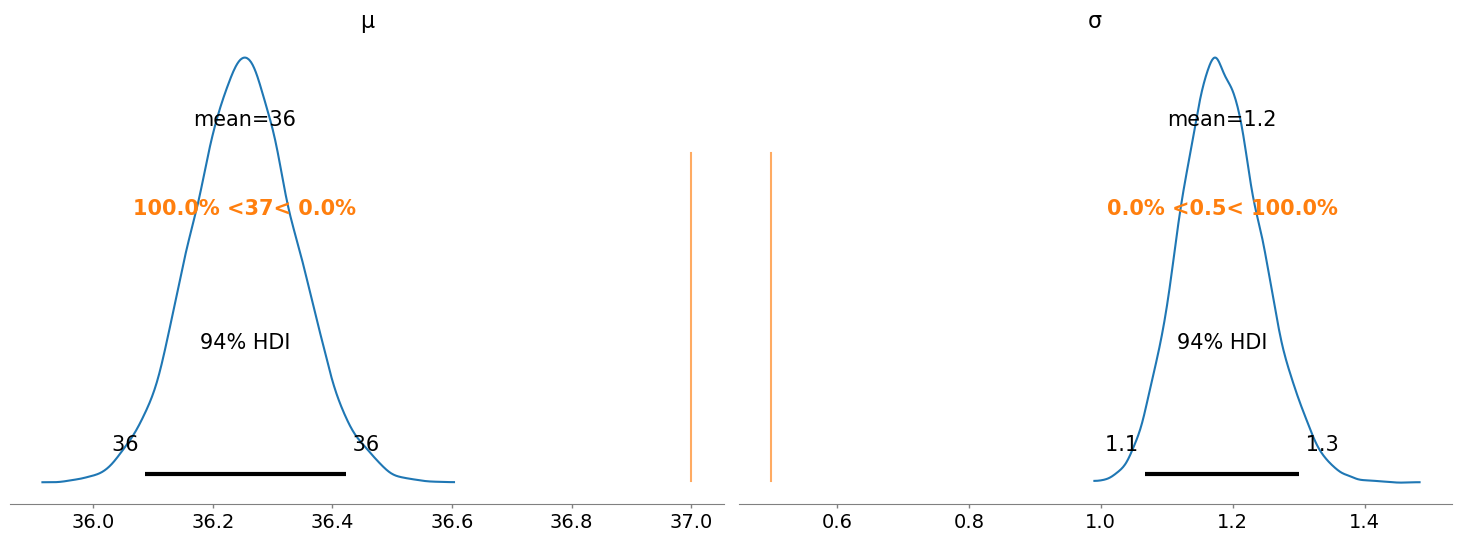

In [41]:
az.plot_posterior(basic_trace, ref_val= {"μ": [{"ref_val": true_temp_mean}], "σ": [{"ref_val": 0.5}]})
plt.tight_layout()

Now the posterior estimates don't look great.  If we simulate some samples from the posterior distribution and compare them to the observed distribution we can get an idea of what's going wrong...

In [42]:
with basic_model:
    basic_trace.extend(pm.sample_posterior_predictive(basic_trace))

Sampling: [Y_obs]


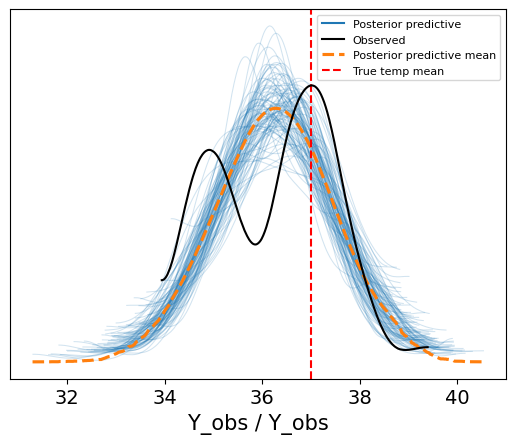

In [44]:
fig, ax = plt.subplots()
az.plot_ppc(basic_trace, ax=ax, num_pp_samples=100)
ax.axvline(true_temp_mean, ls="--", color="r", label="True temp mean")
ax.legend(fontsize=8);

Because our basic model doesn't have any idea about the data heirarchy (there are 3 subsets of measurements, with different characteristics) it's trying to fit one set of paramters for a Normal distribution that are plausible across all 3 thermometers.

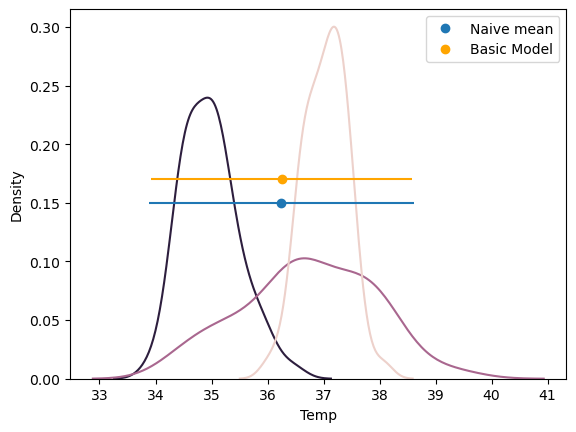

In [49]:
ppmean = basic_trace.posterior_predictive['Y_obs'].mean()
ppconf = basic_trace.posterior_predictive['Y_obs'].quantile(q=[0.025, 0.975])

sns.kdeplot(data=df, x="Temp", hue="Thermometer")
plt.plot(df.Temp.mean(), 0.15, 'o', label='Naive mean')
plt.plot(ppmean, 0.17, 'o', color='orange', label='Basic Model')
plt.hlines(xmin=df.Temp.mean()-2*df.Temp.std(), xmax=df.Temp.mean()+2*df.Temp.std(), y=0.15)
plt.hlines(xmin=ppconf[0], xmax=ppconf[1], y=0.17, color='orange')
plt.legend()

---
## Better model

Rather than estimate a separate mean for each thermometer, we want to partially pool the data, to account for the fact that in principal they are all sampling the same water bath, but have different measurement characteristics.

To do this, we define a `coords` variable, that contains information about which observations belong to which thermometer, and build a model that defines thermometer specific deviations from a 'global' temperature estimate (ie. the true water bath temperature).  The are a few different way this could be done at this point, so check-out the links in Further Reading below for more ideas...

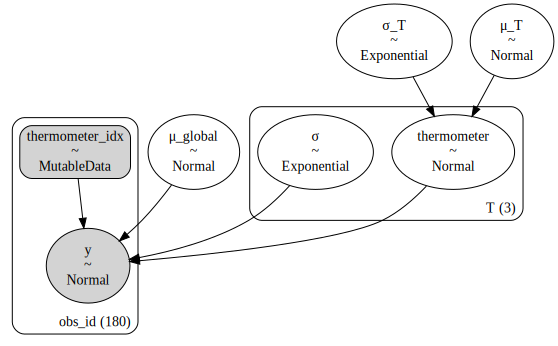

In [50]:
coords = {'T': ['T0', 'T1', 'T2'],
         'obs_id': df.index}
with pm.Model(coords=coords) as better_model:
    thermometer_idx = pm.MutableData("thermometer_idx", obs_idx, dims="obs_id")

    # Hyperpriors
    mu_t = pm.Normal("μ_T", mu=0, sigma=1)
    sigma_t = pm.Exponential("σ_T", 2.0)

    # Varying intercepts
    thermometer = pm.Normal("thermometer", mu=mu_t, sigma=sigma_t, dims="T")

    mu_global = pm.Normal("μ_global", mu=all_obs.mean(), sigma=all_obs.std()*2)
    
    # Expected value
    theta = mu_global + thermometer[thermometer_idx]

    # Uncertainty terms
    a_thermometer_sigma = pm.Exponential("σ", 1, dims="T")
    sigma = a_thermometer_sigma[thermometer_idx]

    y = pm.Normal("y", mu=theta, sigma=sigma, observed=all_obs, dims="obs_id")


pm.model_to_graphviz(better_model)

In [51]:
better_model

Sampling takes a bit longer this time, and because the parameter space is more complex, we tweak the `pm.sample` parameters to aid convergence:

In [52]:
with better_model:
    better_trace = pm.sample(chains=4, target_accept=0.95, return_inferencedata=True)
pm.summary(better_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ_T, σ_T, thermometer, μ_global, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_T,0.02,0.94,-1.68,1.82,0.03,0.02,1251.77,1681.55,1.0
thermometer[T0],0.82,1.10,-1.24,2.78,0.04,0.03,891.56,1157.36,1.0
thermometer[T1],0.49,1.10,-1.65,2.37,0.04,0.03,895.78,1171.64,1.0
thermometer[T2],-1.23,1.09,-3.37,0.68,0.04,0.03,898.60,1169.44,1.0
μ_global,36.21,1.09,34.25,38.27,0.04,0.03,893.60,1196.92,1.0
σ_T,1.06,0.40,0.47,1.79,0.01,0.01,2436.31,2436.16,1.0
σ[T0],0.40,0.04,0.33,0.47,0.00,0.00,2711.98,2682.98,1.0
σ[T1],1.17,0.11,0.96,1.38,0.00,0.00,3419.86,2376.17,1.0
σ[T2],0.52,0.05,0.43,0.61,0.00,0.00,3178.53,2267.72,1.0


Notice how a summary of the model gives you estimates of the individual thermometer characteristics (`thermometer[Tn]` terms) expressed as deviations from the global term `μ_global`, and thermometer specific estimates of their uncertainty `σ[Tn]` terms.

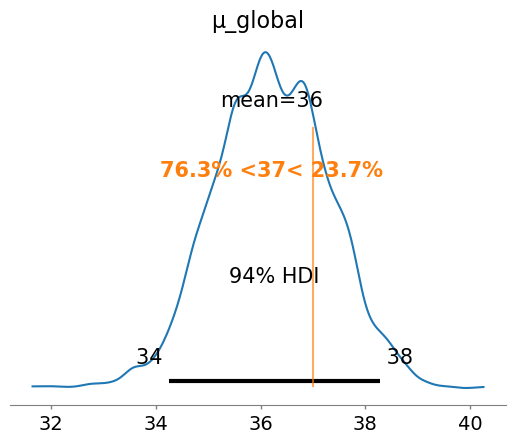

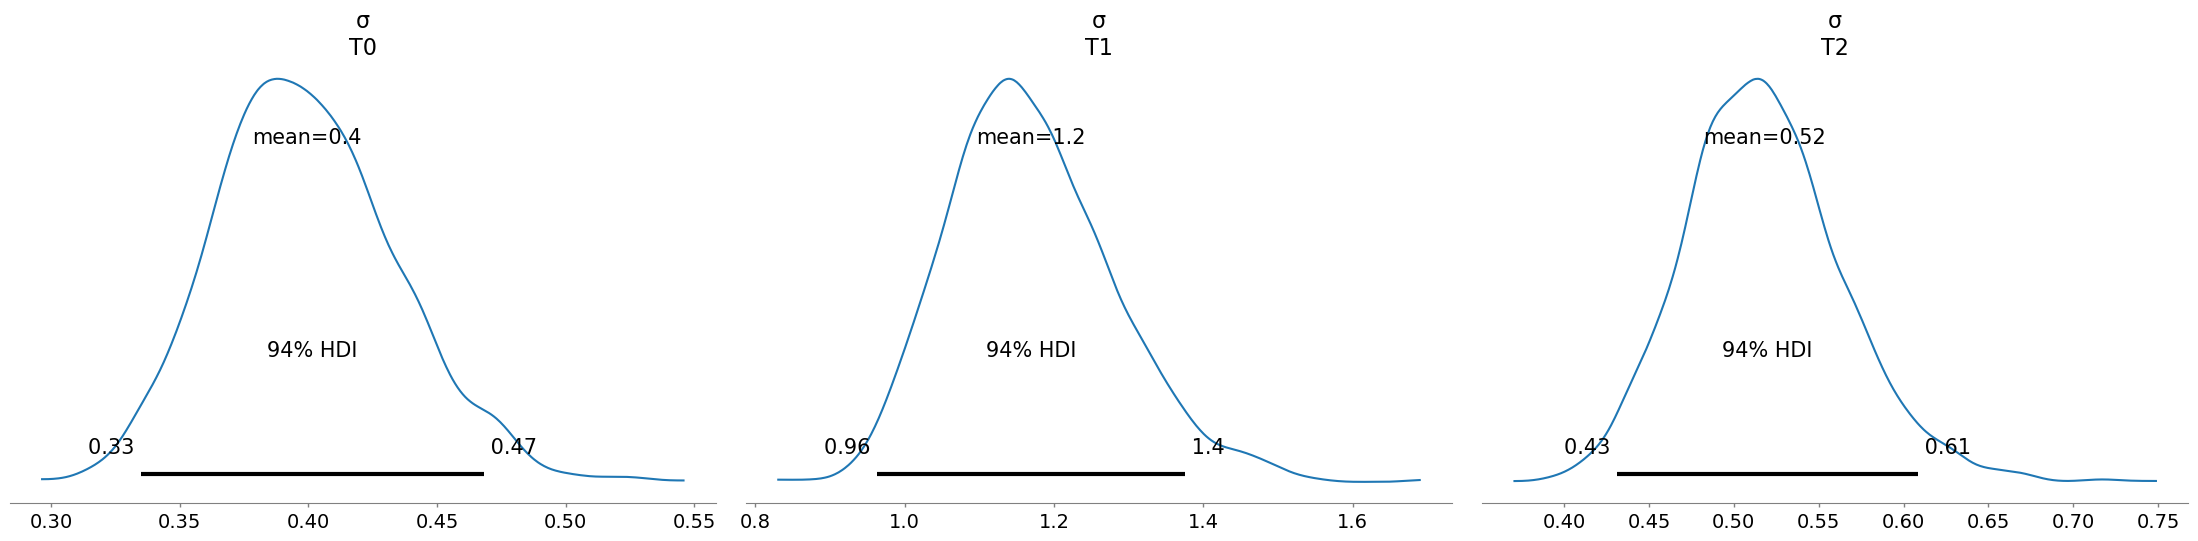

In [56]:
az.plot_posterior(better_trace, var_names=["μ_global"], ref_val= {"μ_global": [{"ref_val": true_temp_mean}]})
az.plot_posterior(better_trace, var_names=["σ"])
plt.tight_layout()

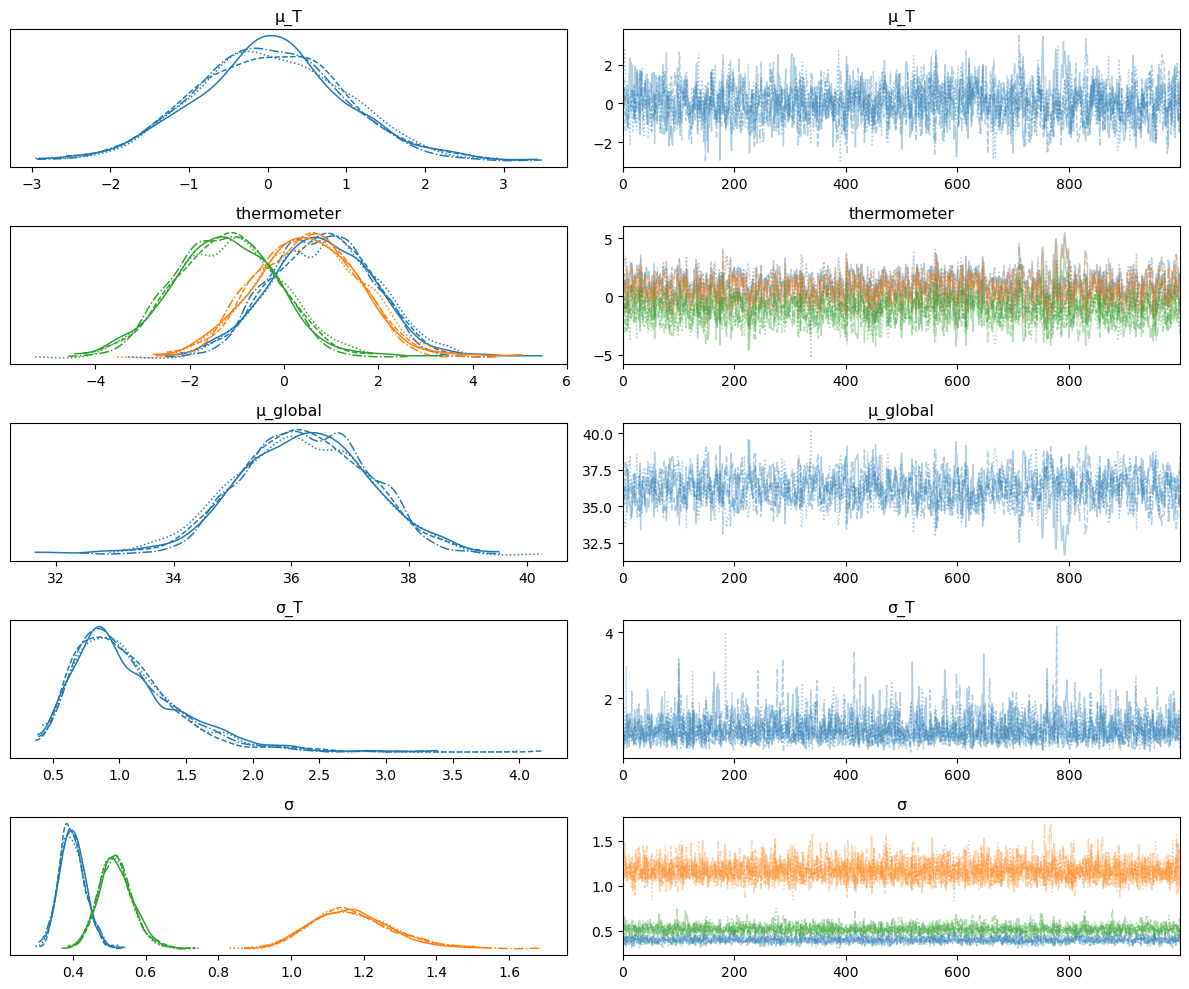

In [57]:
az.plot_trace(better_trace, compact=True)
plt.tight_layout()

Re-simulate from the posterior predictive distribution, and we can see it does a much better job of represeting our observations

In [54]:
with better_model:
    better_trace.extend(pm.sample_posterior_predictive(better_trace))

Sampling: [y]


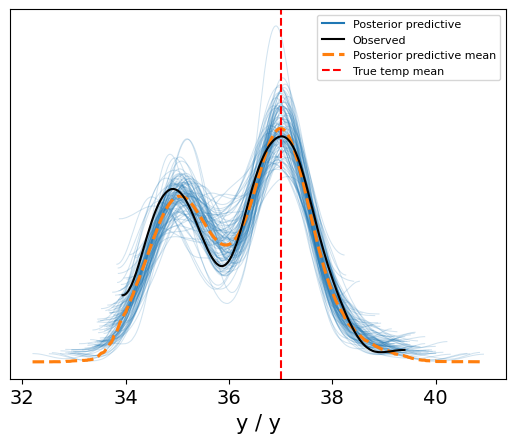

In [55]:
fig, ax = plt.subplots()
az.plot_ppc(better_trace, ax=ax, num_pp_samples=100)
ax.axvline(true_temp_mean, ls="--", color="r", label="True temp mean")
ax.legend(fontsize=8);

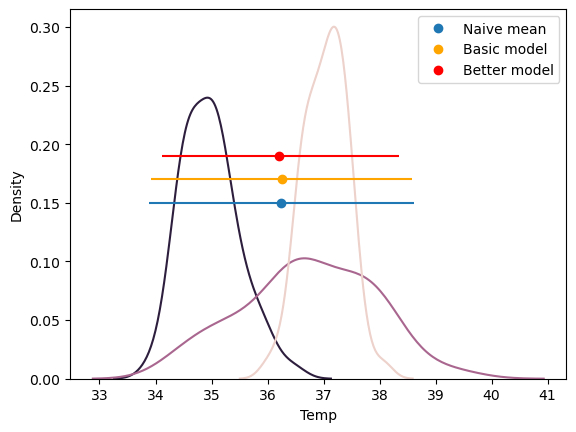

In [66]:
ppmean_better_global = better_trace.posterior['μ_global'].mean()
ppconf_better_global = better_trace.posterior['μ_global'].quantile(q=[0.025, 0.975])

sns.kdeplot(data=df, x="Temp", hue="Thermometer")
plt.plot(df.Temp.mean(), 0.15, 'o', label='Naive mean')
plt.plot(ppmean, 0.17, 'o', color='orange', label='Basic model')
plt.plot(ppmean_better_global, 0.19, 'o', color='red', label='Better model')
plt.hlines(xmin=df.Temp.mean()-2*df.Temp.std(), xmax=df.Temp.mean()+2*df.Temp.std(), y=0.15)
plt.hlines(xmin=ppconf[0], xmax=ppconf[1], y=0.17, color='orange')
plt.hlines(xmin=ppconf_better_global[0], xmax=ppconf_better_global[1], y=0.19, color='red')
plt.legend()

So the better model reduces our uncertainty about the mean.  In this case, with 3 sub-sets of data the effect is quite small, 

## Even more thermometers

Let's examine the influence of adding more data (more thermometers). In this case most are accurate and precise about the true mean.

<Axes: xlabel='Temp', ylabel='Density'>

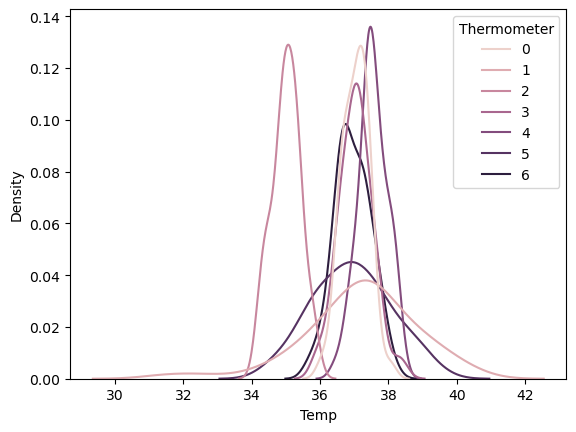

In [69]:
obs_temps0 = obs_temps  # Good, accurate thermometer
obs_temps1 = rng.normal(loc=true_temp_mean, scale=1.5, size=n) # Accurate but imprecise thermometer
obs_temps2 = rng.normal(loc=true_temp_mean-2, scale=0.5, size=n) # Inaccurate (cold bias) but precise thermometer

obs_temps3 = rng.normal(loc=true_temp_mean, scale=0.5, size=n)
obs_temps4 = rng.normal(loc=true_temp_mean+0.5, scale=0.5, size=n)
obs_temps5 = rng.normal(loc=true_temp_mean, scale=1, size=n)
obs_temps6 = rng.normal(loc=true_temp_mean, scale=0.5, size=n)

all_obs = np.array([obs_temps0, 
                    obs_temps1, 
                    obs_temps2,
                    obs_temps3,
                    obs_temps4,
                    obs_temps5,
                    obs_temps6
                   ]).flatten()  # NB. remember the order the array is created

# An array describing which of the obs belong to which thermometer
obs_idx = np.array([np.repeat(0, n), 
                    np.repeat(1, n), 
                    np.repeat(2, n),
                   np.repeat(3, n),
                   np.repeat(4, n),
                   np.repeat(5, n),
                   np.repeat(6, n)]).flatten()
obs_sample = np.tile(range(n), 7)

# Make dataframe
df = pd.DataFrame(data=zip(obs_sample, obs_idx, all_obs), columns=["Sample", "Thermometer", "Temp"], )
sns.kdeplot(data=df, x="Temp", hue="Thermometer")

In [71]:
coords = {'T': ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6'],
         'obs_id': df.index}
with pm.Model(coords=coords) as better_model_more:
    thermometer_idx = pm.MutableData("thermometer_idx", obs_idx, dims="obs_id")

    # Hyperpriors
    mu_t = pm.Normal("μ_T", mu=0, sigma=1)
    sigma_t = pm.Exponential("σ_T", 2.0)

    # Varying intercepts
    thermometer = pm.Normal("thermometer", mu=mu_t, sigma=sigma_t, dims="T")

    mu_global = pm.Normal("μ_global", mu=all_obs.mean(), sigma=all_obs.std()*2)
    
    # Expected value
    theta = mu_global + thermometer[thermometer_idx]

    # Uncertainty terms
    a_thermometer_sigma = pm.Exponential("σ", 1, dims="T")
    sigma = a_thermometer_sigma[thermometer_idx]

    y = pm.Normal("y", mu=theta, sigma=sigma, observed=all_obs, dims="obs_id")

In [77]:
with better_model_more:
    better_trace_more = pm.sample(chains=4, target_accept=0.95, return_inferencedata=True)
pm.summary(better_trace_more, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ_T, σ_T, thermometer, μ_global, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_T,-0.05,0.90,-1.74,1.61,0.03,0.02,875.70,1362.50,1.01
thermometer[T0],0.18,0.94,-1.66,1.85,0.03,0.02,810.49,1260.74,1.01
thermometer[T1],0.29,0.96,-1.46,2.13,0.03,0.02,833.04,1323.26,1.01
thermometer[T2],-1.83,0.94,-3.65,-0.12,0.03,0.02,813.44,1198.79,1.01
thermometer[T3],0.19,0.94,-1.56,1.97,0.03,0.02,813.12,1232.90,1.01
thermometer[T4],0.68,0.94,-1.09,2.43,0.03,0.02,817.13,1237.96,1.01
thermometer[T5],0.07,0.95,-1.71,1.81,0.03,0.02,817.09,1226.18,1.01
thermometer[T6],0.10,0.94,-1.72,1.80,0.03,0.02,815.28,1206.82,1.01
μ_global,36.85,0.94,35.23,38.75,0.03,0.02,811.06,1238.66,1.01
σ_T,0.86,0.25,0.48,1.34,0.00,0.00,3474.62,2224.38,1.00


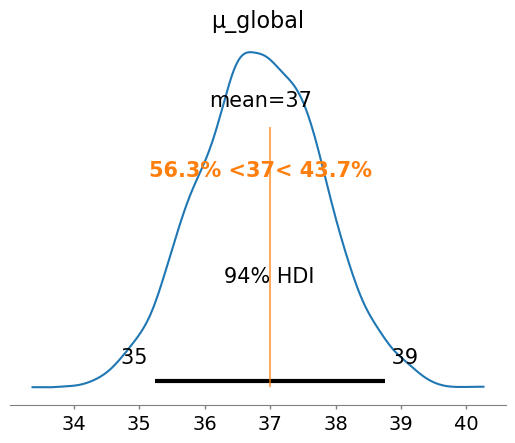

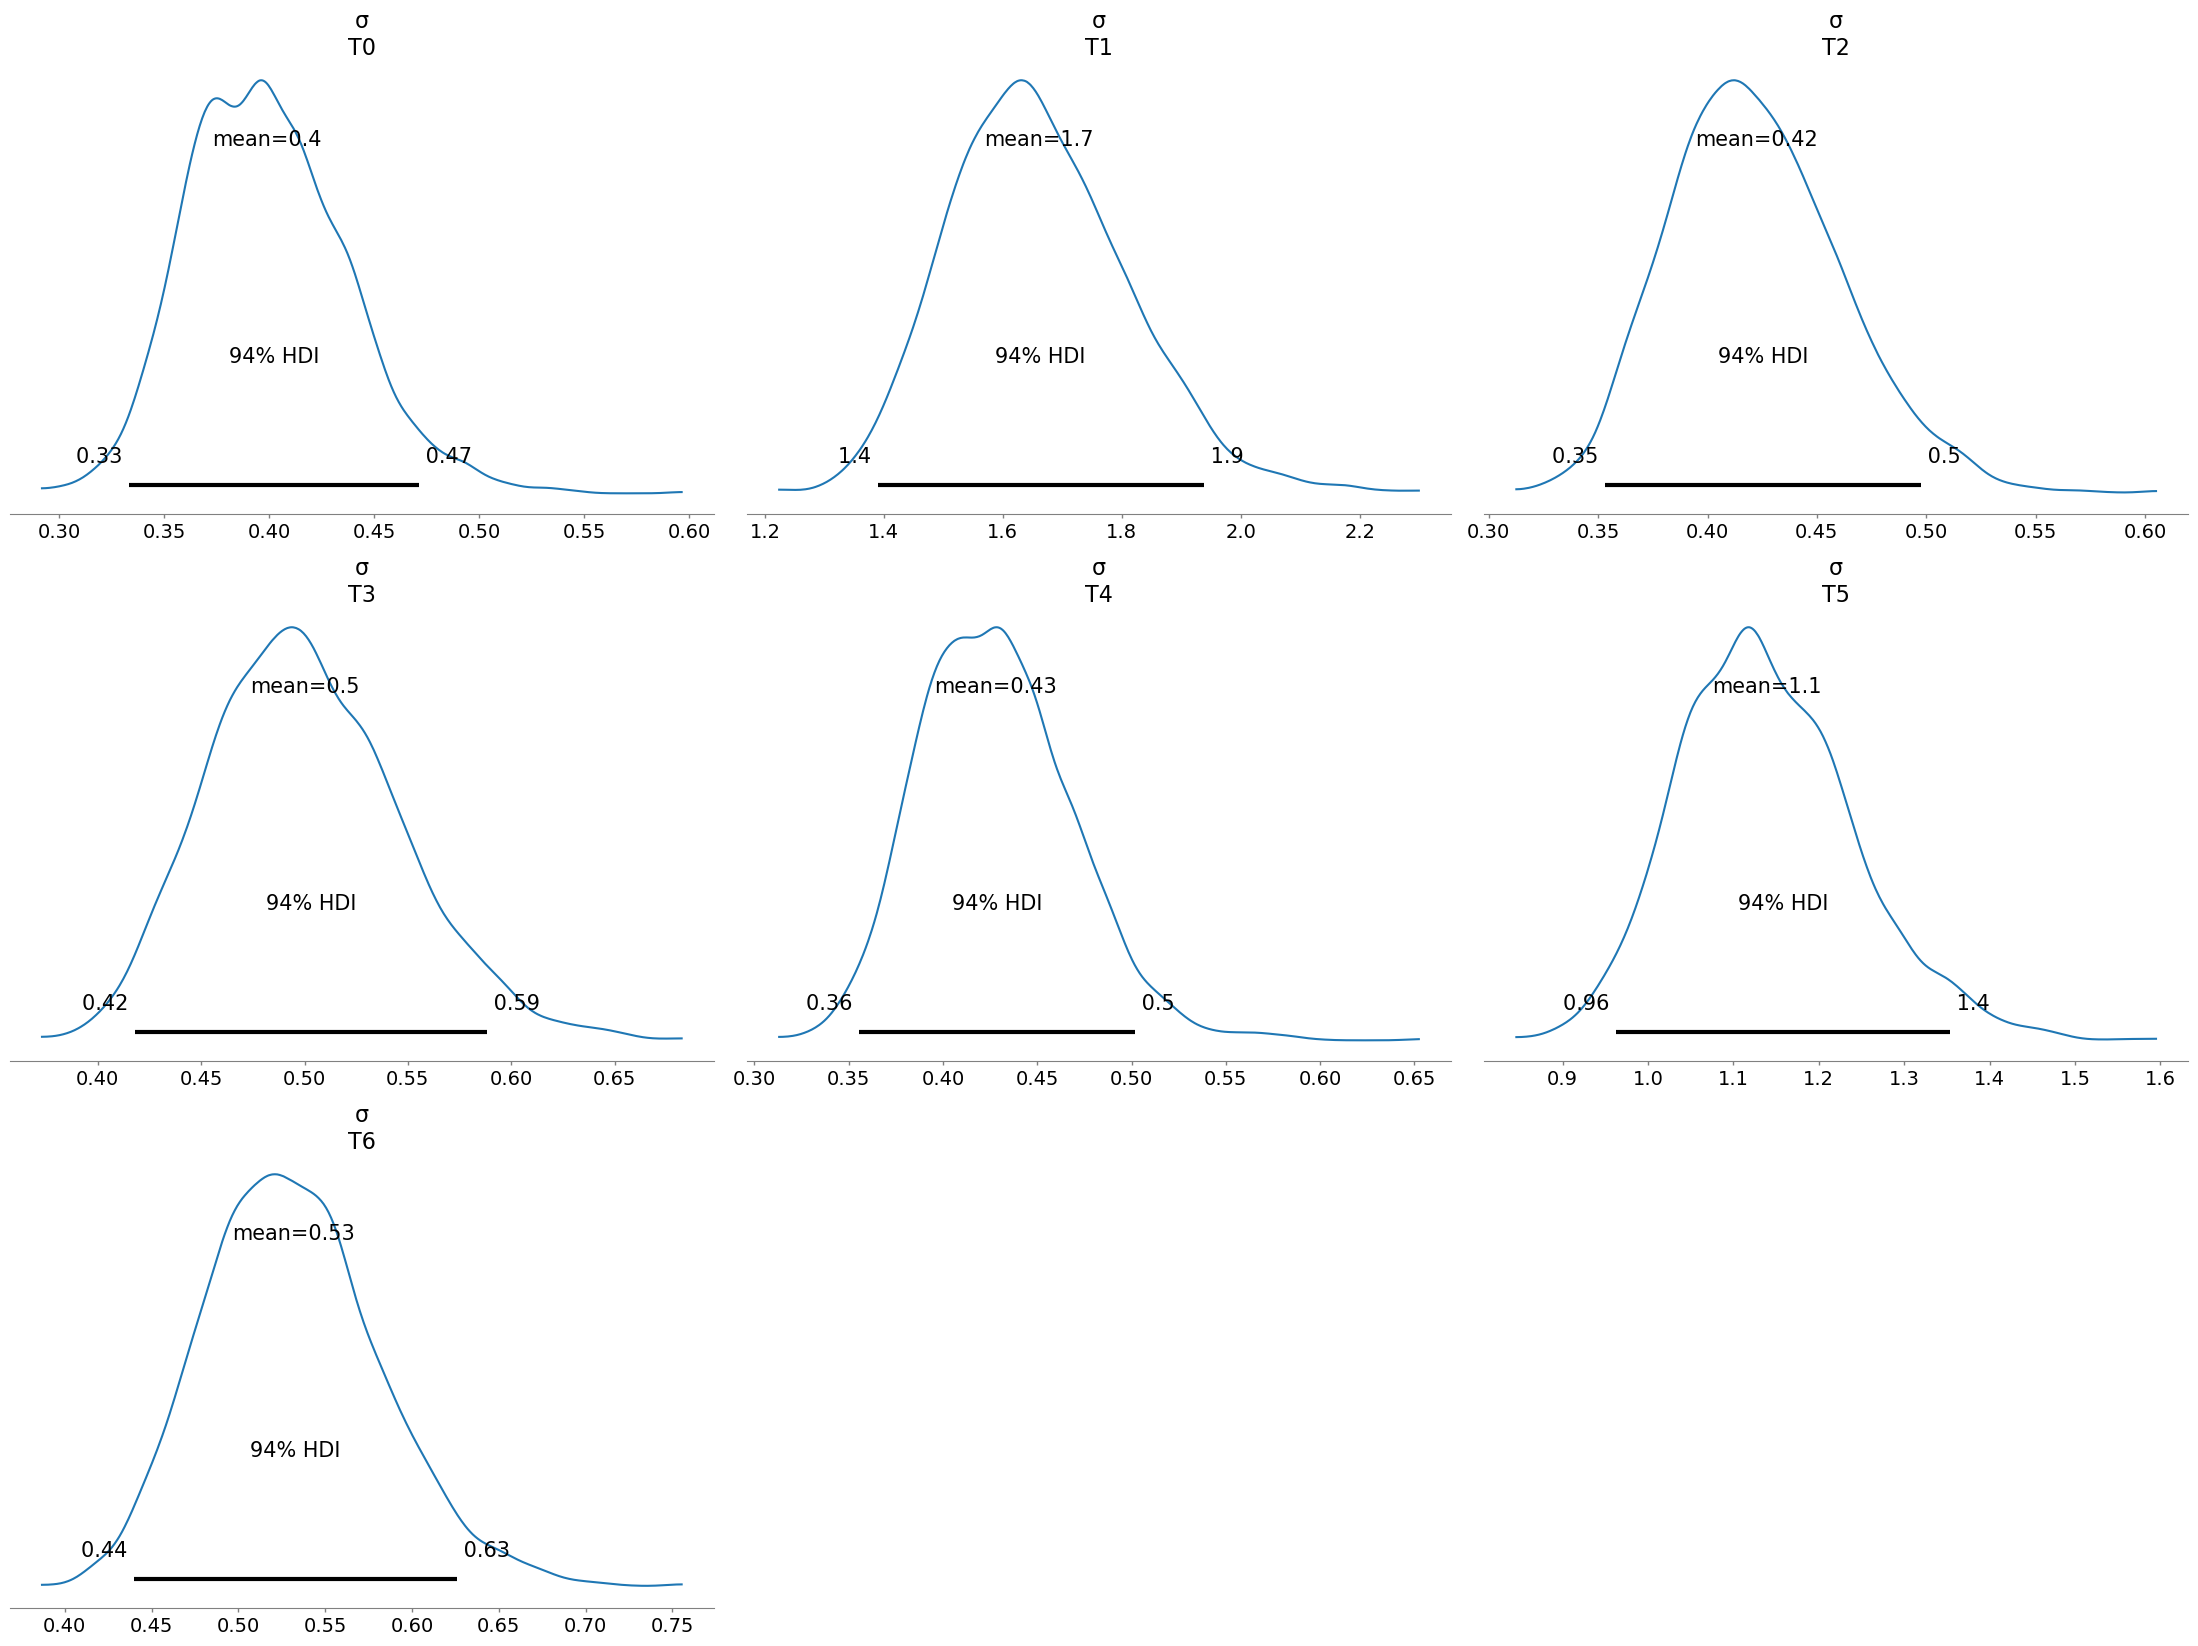

In [78]:
az.plot_posterior(better_trace_more, var_names=["μ_global"], ref_val= {"μ_global": [{"ref_val": true_temp_mean}]})
az.plot_posterior(better_trace_more, var_names=["σ"])
plt.tight_layout()

In [79]:
with better_model_more:
    better_trace_more.extend(pm.sample_posterior_predictive(better_trace_more))

Sampling: [y]


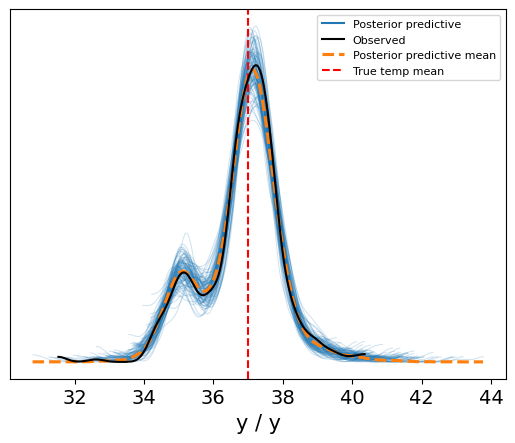

In [81]:
fig, ax = plt.subplots()
az.plot_ppc(better_trace_more, ax=ax, num_pp_samples=100)
ax.axvline(true_temp_mean, ls="--", color="r", label="True temp mean")
ax.legend(fontsize=8);

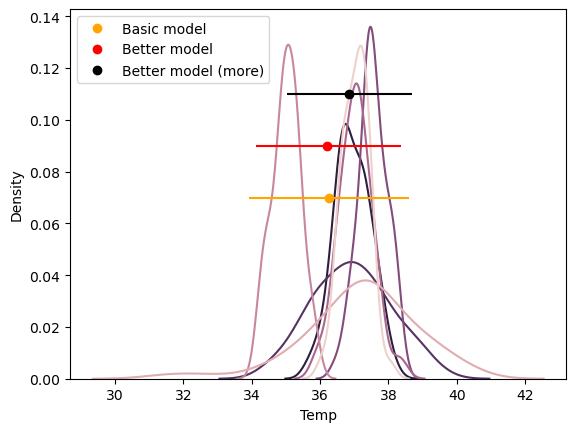

In [102]:
ppmean_better_global_more = better_trace_more.posterior['μ_global'].mean()
ppconf_better_global_more = better_trace_more.posterior['μ_global'].quantile(q=[0.025, 0.975])

sns.kdeplot(data=df, x="Temp", hue="Thermometer")
# plt.plot(df.Temp.mean(), 0.05, 'o', label='Naive mean')
plt.plot(ppmean, 0.07, 'o', color='orange', label='Basic model')
plt.plot(ppmean_better_global, 0.09, 'o', color='red', label='Better model')
plt.plot(ppmean_better_global_more, 0.11, 'o', color='black', label='Better model (more)')
# plt.hlines(xmin=df.Temp.mean()-2*df.Temp.std(), xmax=df.Temp.mean()+2*df.Temp.std(), y=0.05)
plt.hlines(xmin=ppconf[0], xmax=ppconf[1], y=0.07, color='orange')
plt.hlines(xmin=ppconf_better_global[0], xmax=ppconf_better_global[1], y=0.09, color='red')
plt.hlines(xmin=ppconf_better_global_more[0], xmax=ppconf_better_global_more[1], y=0.11, color='black')
plt.legend()

## Taking things further...

What other improvements could we make to our model?  

Are there different distributions that might suite our data better? 

How might we alternatively formulate our model equations?

---
# Further Reading

There is lots more further reading and helpful tutorials availble at the following links:

* [PyMC Baseball example](https://www.pymc.io/projects/examples/en/latest/case_studies/hierarchical_partial_pooling.html)
* [PyMC Radon example (A Primer on Bayesian Methods for Multilevel Modeling)](https://www.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html#benefits-of-multilevel-models)
* [Hierarchical Linear regression (blog post, also based on radon data)](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)
* [Computational Statistics for Bayesian Inference with PyMC (tutorial)](https://sjster.github.io/introduction_to_computational_statistics/docs/index.html)
* ... from above, [Hierarchical Linear Regression](https://sjster.github.io/introduction_to_computational_statistics/docs/Production/PyMC3.html#hierarchical-linear-regression)

---

In [103]:
%load_ext watermark

In [109]:
%watermark -iv -v

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

numpy     : 1.24.3
matplotlib: 3.7.1
pymc      : 5.3.0
pandas    : 1.5.3
seaborn   : 0.12.2
arviz     : 0.15.1

